In [1]:
import numpy as np
import pandas as pd
import pickle
import cv2
import glob
import os

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

import cam_cal   as cal
import cv_transf as cvt
import pipeline  as pl
import lines     as lf

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



In [2]:
def get_original(dirname, file_names, idx=-1):
    # digit unique identifies a particular image 
    sample = idx if idx != -1 else np.random.randint(len(fnames))
    fname = file_names[sample]
    digit = "".join([ch for ch in fname if ch.isdigit()])    
    return fname, digit
    
def get_filename(dirname, digit, prefix):
    dirname = "_".join([dirname, 'tracked'])
    fname   = "".join([prefix, digit, '.jpg'])
    fname   = os.path.join(dirname, fname)
    return fname

dirname = 'test_images'
pattern = 'test'
ext     = '.jpg'
fnames  = glob.glob(os.path.join(dirname, 'test*.jpg'))

## Camera Calibration

In [3]:
# retrieve chessboard object point(3D) image point(2D) transformation to be used for camera calibration
img_points, obj_points, file_names = \
cal.camera_chessboard('camera_cal', 'calibration', '.jpg', nx=9, ny=6)
# calibrate camera
cal_img = mpimg.imread(file_names[0][0])
cal_img_size = (cal_img.shape[::-1])[:2]
mtx, dist_coef = cal.camera_calibrate(img_points, obj_points, cal_img_size)
# serialize camera matrix(mtx), distortion coefficients to disk
if not os.path.exists('./ckpts'): os.makedirs('./ckpts')
with open('./ckpts/calibration.p', 'wb') as f:
    pickle.dump({'mtx': mtx, 'dist_coef': dist_coef}, f)
# get already serialized calibration matrix
with open('./ckpts/calibration.p', 'rb') as f:
    data_dict = pickle.load(f)
    mtx  = data_dict['mtx']
    dist = data_dict['dist_coef']
    del data_dict

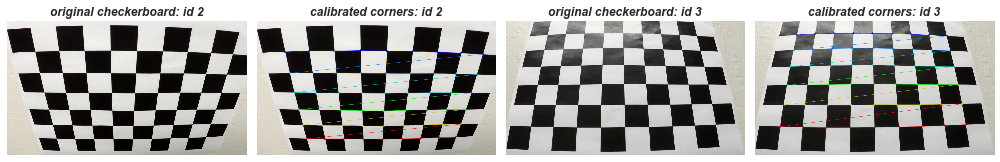

In [4]:
def set_axi_opts(axi, **kwargs):
    axi.grid(False)
    axi.get_yaxis().set_visible(False)
    axi.get_xaxis().set_ticks([])
    fontsize=12
    if 'fontsize' in kwargs: fontsize=kwargs['fontsize']
    params = {'fontweight':'bold', 'fontstyle':'italic', 'fontsize': fontsize}
    if 'title'  in kwargs: axi.set_title(kwargs['title'], **params)
    if 'xlabel' in kwargs: axi.set_xlabel(kwargs['xlabel'], **params)
        
def view_chessboard_pattern(ax1, ax2, img_idx):
    fname = 'camera_cal/calibration{}.jpg'.format(str(img_idx))
    fname_corner = 'camera_cal_corners/cal_corners{}.jpg'.format(str(img_idx))
    ax1.imshow(mpimg.imread(fname))
    set_axi_opts(ax1, **{'title': 'original checkerboard: id {}'.format(str(img_idx))})
    ax2.imshow(mpimg.imread(fname_corner))
    set_axi_opts(ax2, **{'title': 'calibrated corners: id {}'.format(str(img_idx))})

# show chessboard pattern calibration
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(14,8))
view_chessboard_pattern(ax1, ax2, 2)
view_chessboard_pattern(ax3, ax4, 3)
plt.tight_layout()
fig.savefig('./output_images/calibration.png', transparent=False, bbox_inches='tight')

## Gradient Thresholding
- Comparing the different thresholding techniques on a sample image 

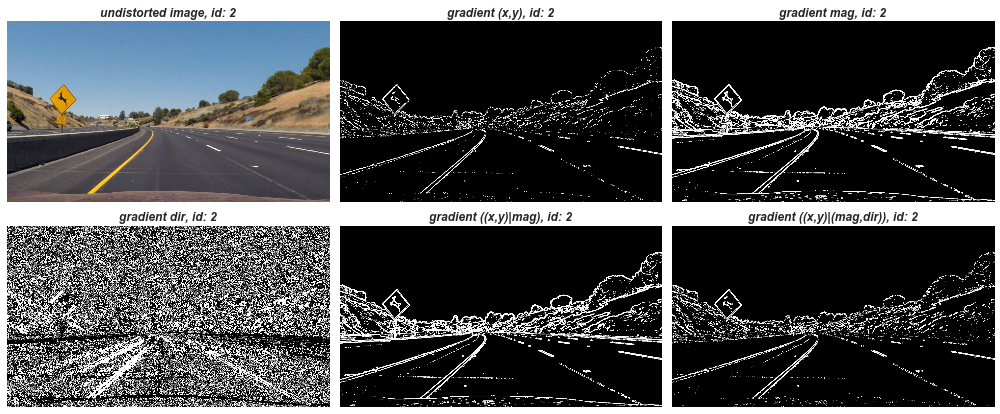

In [5]:
fig, ax = plt.subplots(2,3, figsize=(14,6))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
fname, digit = get_original(dirname, fnames, idx=1)
# raw image
base_img = mpimg.imread(fname)
rows, cols = base_img.shape[:2]
# undistorted image
undist_img = cv2.undistort(base_img, mtx, dist, None, mtx)
ax1.imshow(undist_img)
set_axi_opts(ax1, **{'title': 'undistorted image, id: {}'.format(digit)})
# gradient 
grad_x = cvt.abs_sobel_orient_thresh(undist_img, orient='x', thresh=(12,255))
grad_y = cvt.abs_sobel_orient_thresh(undist_img, orient='y', thresh=(25,255))
grad_orient  = np.zeros_like(undist_img[:,:, 0])
grad_orient[( (grad_x == 1) & (grad_y == 1)  )] = 255
ax2.imshow(grad_orient, cmap='gray')
set_axi_opts(ax2, **{'title': 'gradient (x,y), id: {}'.format(digit)})
# magnitude gradient
grad_mag = cvt.mag_sobel_thresh(undist_img, 5, (25,255))
ax3.imshow(grad_mag, cmap='gray')
set_axi_opts(ax3, **{'title': 'gradient mag, id: {}'.format(digit)})
# directional gradient
grad_dir = cvt.dir_sobel_thresh(undist_img, 15, (0.7,1.3))
ax4.imshow(grad_dir, cmap='gray')
set_axi_opts(ax4, **{'title': 'gradient dir, id: {}'.format(digit)})
# combined gradients
grad_comb_binary = np.zeros_like(grad_mag)
grad_comb_binary[( ((grad_x == 1) & (grad_y == 1)) | (grad_mag == 1) )] = 1
ax5.imshow(grad_comb_binary, cmap='gray')
set_axi_opts(ax5, **{'title': 'gradient ((x,y)|mag), id: {}'.format(digit)})
# combined gradients
grad_comb_binary = np.zeros_like(grad_dir)
grad_comb_binary[( ((grad_x == 1) & (grad_y == 1)) | ((grad_mag == 1) & (grad_dir == 1)) )] = 1
ax6.imshow(grad_comb_binary, cmap='gray')
set_axi_opts(ax6, **{'title': 'gradient ((x,y)|(mag,dir)), id: {}'.format(digit)})


plt.tight_layout()
fig.savefig('./output_images/gradient_exploration.png', transparent=False, bbox_inches='tight')

## Color Thresholding
- Comparing the different color thresholding on an undistorted image

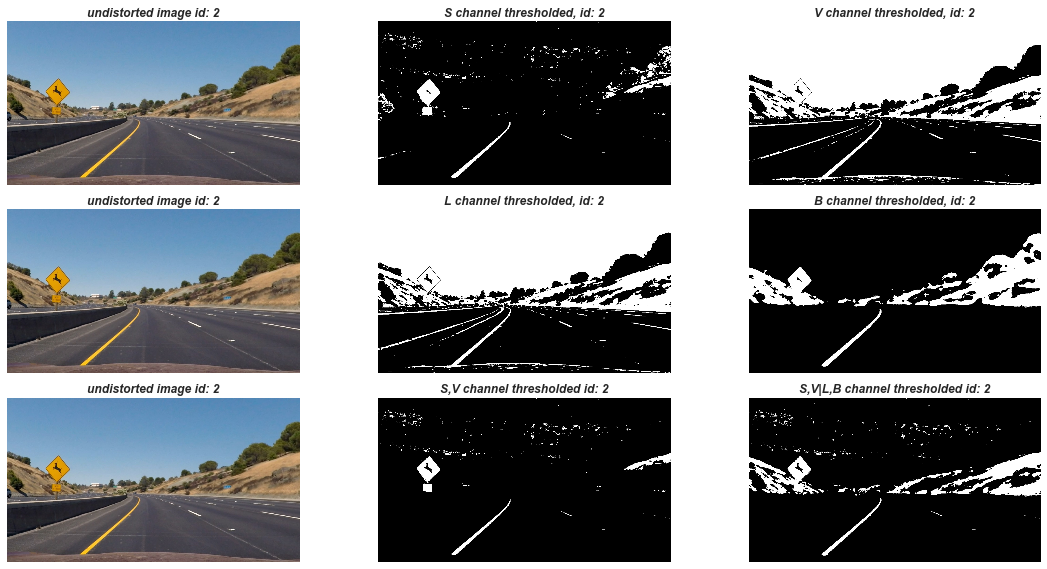

In [6]:
def show_channel_thresholded(channel, threshold, fmt, axi):
    channel_binary = cvt.channel_threshold(channel, thresh=threshold)
    axi.imshow(channel_binary, cmap='gray')
    set_axi_opts(axi, **{'title': '{} channel thresholded, id: {}'.format(*fmt)})
    return channel_binary

fig,ax = plt.subplots(3,3, figsize=(16,8))
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9 = ax.flatten()
# undistorted
ax1.imshow(undist_img)
set_axi_opts(ax1, **{'title': '{} image id: {}'.format('undistorted',digit)})
# S channel
hls = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)
S = hls[:,:,2]
S_binary = cvt.channel_threshold(S, thresh=(110,255))
show_channel_thresholded(S, (110,255), ('S', digit), ax2)
# V channels
hsv = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HSV)
V = hsv[:,:,2]
V_binary = cvt.channel_threshold(V, thresh=(130,255))
show_channel_thresholded(V, (130,255), ('V', digit), ax3)

#undistored
ax4.imshow(undist_img)
set_axi_opts(ax4, **{'title': '{} image id: {}'.format('undistorted',digit)})
# L Channel 
luv = cv2.cvtColor(undist_img, cv2.COLOR_RGB2LUV)
L   = luv[:,:,0]
L_binary = cvt.channel_threshold(L, thresh=(125,255))
show_channel_thresholded(L, (125,255), ('L', digit), ax5)
# B channel
lab = cv2.cvtColor(undist_img, cv2.COLOR_RGB2LAB)
B   = lab[:,:,2]
B_binary = cvt.channel_threshold(B, thresh=(145,255))
show_channel_thresholded(B, (145,255), ('B', digit), ax6)

#undistored
ax7.imshow(undist_img)
set_axi_opts(ax7, **{'title': '{} image id: {}'.format('undistorted',digit)})
# S, V channels
color_comb_binary = np.zeros_like(S)
color_comb_binary[(S_binary == 1) & (V_binary == 1)] = 1
ax8.imshow(color_comb_binary, cmap='gray')
set_axi_opts(ax8, **{'title': '{} channel thresholded id: {}'.format("S,V",digit)})
# S,V,L,B channels
color_comb_binary = np.zeros_like(L)
color_comb_binary[( (S_binary == 1) & (V_binary == 1) ) |( (L_binary == 1) & (B_binary == 1)  )] = 1
ax9.imshow(color_comb_binary, cmap='gray')
set_axi_opts(ax9, **{'title': '{} channel thresholded id: {}'.format("S,V|L,B",digit)})

plt.tight_layout()
fig.savefig('./output_images/color_exploration.png', transparent=False, bbox_inches='tight')

## Combining Gradient and Color Channel Thresholds
- Use the combined color channels and Gradients for the perspective Transform

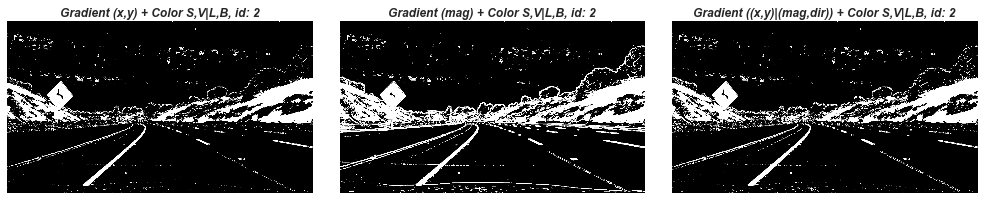

In [7]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(14,8))
# combine grad(x,y), combined colors
thresh_comb_binary  = np.zeros_like(undist_img[:,:, 0])
thresh_comb_binary[( (grad_x == 1) & (grad_y == 1) | (color_comb_binary == 1) )] = 255
ax1.imshow(thresh_comb_binary, cmap='gray')
set_axi_opts(ax1, **{'title': 'Gradient {} + Color {}, id: {}'.format("(x,y)","S,V|L,B",digit)})
# combine grad magnitude + color 
thresh_comb_binary  = np.zeros_like(undist_img[:,:, 0])
thresh_comb_binary[( (grad_mag == 1) | (color_comb_binary == 1) )] = 255
ax2.imshow(thresh_comb_binary, cmap='gray')
set_axi_opts(ax2, **{'title': 'Gradient {} + Color {}, id: {}'.format("(mag)","S,V|L,B",digit)})
# combine grad (mag,(x,y), dir) + color
thresh_comb_binary  = np.zeros_like(undist_img[:,:, 0])
thresh_comb_binary[( (grad_comb_binary == 1) | (color_comb_binary == 1) )] = 255
ax3.imshow(thresh_comb_binary, cmap='gray')
set_axi_opts(ax3, **{'title': 'Gradient {} + Color {}, id: {}'.format("((x,y)|(mag,dir))","S,V|L,B",digit)})

thresh_comb_binary  = np.zeros_like(undist_img[:,:, 0])
thresh_comb_binary[( (grad_comb_binary == 1) | (color_comb_binary == 1) )] = 255
plt.tight_layout()
fig.savefig('./output_images/gradient_color_exploration.png', transparent=False, bbox_inches='tight')

## Region of Interest Masking

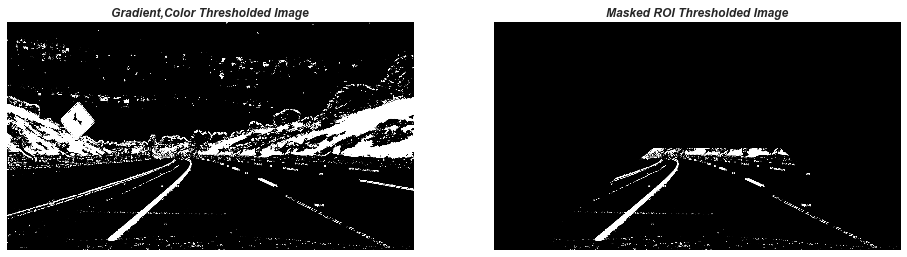

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
roi_binary = pl.pipeline_roi(thresh_comb_binary)
ax1.imshow(thresh_comb_binary, cmap='gray')
set_axi_opts(ax1, **{'title': 'Gradient,Color Thresholded Image'})
ax2.imshow(roi_binary, cmap='gray')
set_axi_opts(ax2, **{'title': 'Masked ROI Thresholded Image'})
fig.savefig('./output_images/roi_exploration.png', transparent=False, bbox_inches='tight')

## Perspective Transform Mappings
- Explore source and destination point mappings
- Explore mappings to warped files

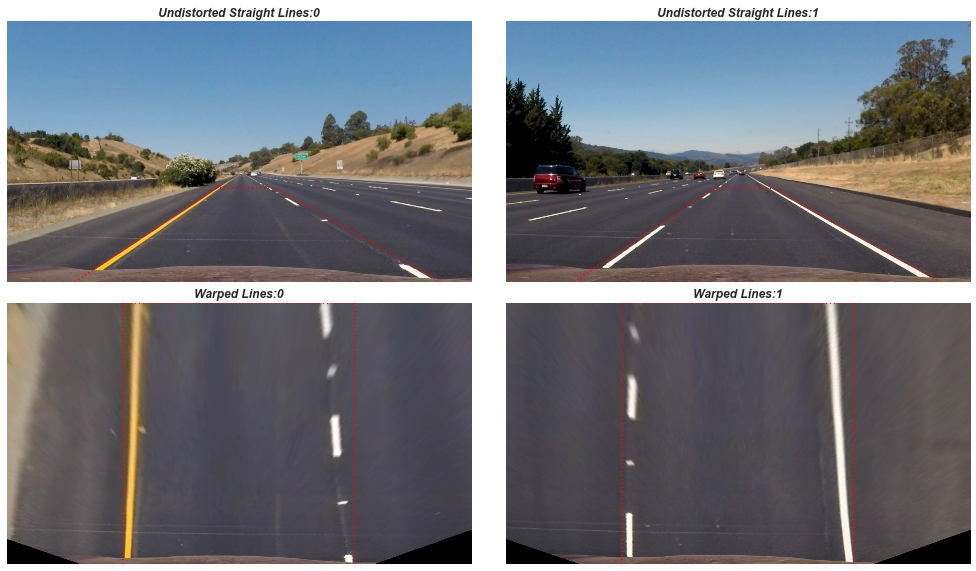

In [9]:
def project_mappings(proj_img, pts, title_str, axi):
    axi.imshow(proj_img)
    set_axi_opts(axi, **{'title': title_str})
    axi.add_line(Line2D(*zip(pts[0], pts[1]), linewidth=2, color='red', ls=':'))
    axi.add_line(Line2D(*zip(pts[2], pts[3]), linewidth=2, color='red', ls=':'))
    axi.add_line(Line2D(*zip(pts[0], pts[3]), linewidth=2, color='red', ls=':'))

# Project mappings on straight lines    
fig, ax = plt.subplots(2,2, figsize=(14,8))
src,dst = pl.create_perspective_mappings(undist_img)
s_files = ['test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg']
opt = {'image_only': True}
s_imgs = [mpimg.imread(st_img) for st_img in s_files]
s_undist_imgs = [cv2.undistort(st_img, mtx, dist, None, mtx) for st_img in s_imgs]
s_warped_imgs = [cvt.perspective_transf(st_img, src, dst, **opt) for st_img in s_undist_imgs]

project_mappings(s_undist_imgs[0], src, "Undistorted Straight Lines:0", ax[0][0])
project_mappings(s_undist_imgs[1], src, "Undistorted Straight Lines:1", ax[0][1])
project_mappings(s_warped_imgs[0], dst, "Warped Lines:0", ax[1][0])
project_mappings(s_warped_imgs[1], dst, "Warped Lines:1", ax[1][1])

plt.tight_layout()
fig.savefig('./output_images/perspective_point_mapping.png', transparent=False, bbox_inches='tight')

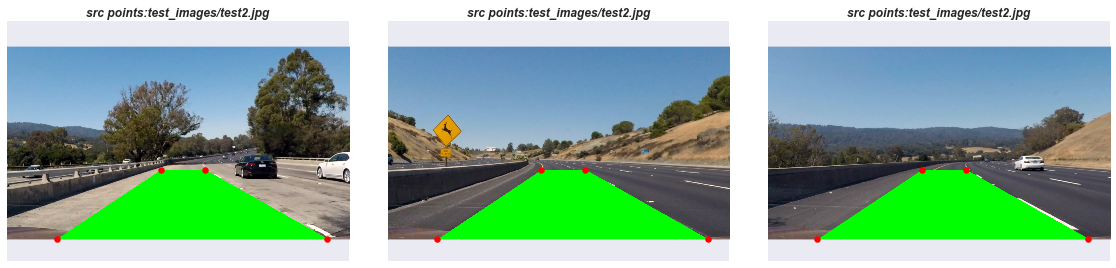

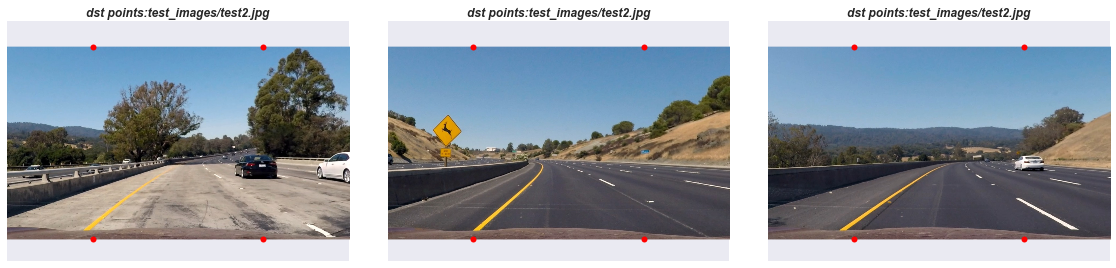

In [10]:
def show_perspective_mappings(img, ax1, ax2):
    src,dst = pl.create_perspective_mappings(img)
    ax1.imshow(img)
    set_axi_opts(ax1, **{'title': 'src points:{}'.format(fname), 'fontsize': 12})
    _ = [ax1.plot(*tup, '.', color='r', markersize=13) for tup in src]
    pst_img = np.copy(img)
    cv2.fillPoly(img, pts=np.int32([src]), color=(0,255,0))
    ax2.imshow(pst_img)
    set_axi_opts(ax2, **{'title': 'dst points:{}'.format(fname), 'fontsize': 12})
    _ = [ax2.plot(*tup, '.', color='r', markersize=12) for tup in dst]

fig1, ax1 = plt.subplots(1,3, figsize=(16,6))
plt.tight_layout()
fig2, ax2 = plt.subplots(1,3, figsize=(16,6))
plt.tight_layout()

file_names, digits_map = zip(*[get_original(dirname, fnames, it) for it in range(5)])
for it, (fname_it, digit_it) in zip(range(3), zip(file_names, digits_map)):
    base_img = mpimg.imread(fname_it)
    random_undist_img = cv2.undistort(base_img, mtx, dist, None, mtx)
    axi1, axi2 = (ax1[it], ax2[it])
    show_perspective_mappings(random_undist_img, axi1, axi2)
fig1.savefig('./output_images/perspective_exploration.png', transparent=False, bbox_inches='tight')    

## Pipeline
Visualize the base pipeline based on explorations from above 
- Undistort Image Using Camera Matrix
- Color/Gradient Threshold
- Apply Region of Interest (ROI) to concentrate on respective lane lines
- Estimate Source and Destination Point Mapping for warped image
- Apply Perspective Transform for warped image per Birds-Eye View

In [11]:
# perform the base pipeline (does include pixel line fit and cuvature)    
pl.pipeline_images(dirname, pattern, ext, method_base=True)

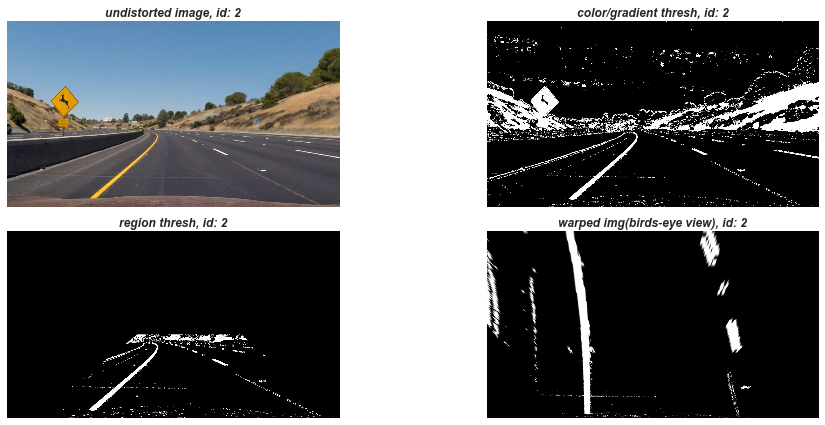

In [12]:
### visualize the base pipeline
fig, ax  = plt.subplots(2,2, figsize=(15,6))
ax1,ax2,ax3,ax4 = ax.flatten()
# undistorted image
fname_undist = get_filename(dirname, digit, prefix='tracked_undistorted')
ax1.imshow(mpimg.imread(fname_undist))
set_axi_opts(ax1, **{'title': 'undistorted image, id: {}'.format(digit)})
# gradient/color thresholded binary image
fname_gc = get_filename(dirname, digit, prefix='tracked_gc_binary')
ax2.imshow(mpimg.imread(fname_gc), cmap='gray')
set_axi_opts(ax2, **{'title': 'color/gradient thresh, id: {}'.format(digit)})
# masked region of interest (ROI)
fname_roi = get_filename(dirname, digit, prefix='tracked_roi_binary')
ax3.imshow(mpimg.imread(fname_roi), cmap='gray')
set_axi_opts(ax3, **{'title': 'region thresh, id: {}'.format(digit)})
# perspective transform
fname_warped = get_filename(dirname, digit, prefix='tracked_warped_binary')
ax4.imshow(mpimg.imread(fname_warped), cmap='gray')
set_axi_opts(ax4, **{'title': 'warped img(birds-eye view), id: {}'.format(digit)})
plt.tight_layout()
fig.savefig('./output_images/pipeline_base.png', transparent=False, bbox_inches='tight')

## Associate Pixels to Lines
- Approximate starting baseline for left and right lanes from image via histogram (for comparison purposes)
- Apply Convolution Sliding Window Method instead of Averaging Method

Peaks(x) left: 387, midpoint: 640, right: 947


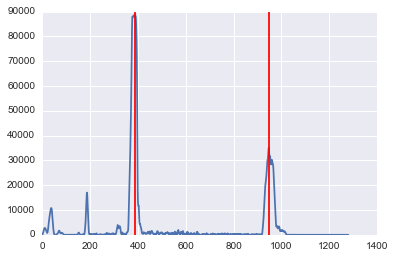

In [13]:
# determine estimated peaks initally before convolution method
warped_img = mpimg.imread(fname_warped)
rows, cols = warped_img.shape[:2]
histogram, leftx_current, rightx_current = lf.find_hist_peaks(warped_img)
plt.plot(histogram)
plt.axvline(x=leftx_current,  color='r')
plt.axvline(x=rightx_current, color='r')

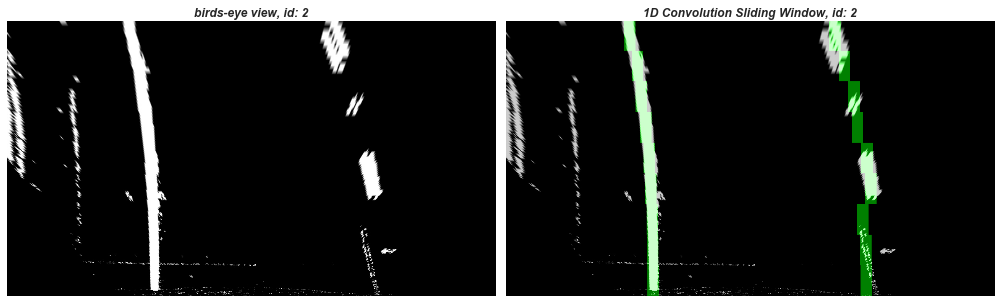

In [14]:
# define configuration for 1D convolution
params = {'window_width':  30,
          'window_height': rows/9,            # rows/n_windows(9)
          'window_margin': 25,
          'ym_per_pix':    10/rows,           # 10m ~ 720 pixels 
          'xm_per_pix':    4/600,             # 4m  ~ 600 pixels
          'smooth_factor': 15,
          'img_dim':       (rows,cols)}
# associate pixels to lines
conv_centers = lf.LineConv1D(**params)
window_centroids = conv_centers.find_window_centroids(warped_img)
conv_img = conv_centers.draw_centroids(warped_img, window_centroids)
# compare image pipeline
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
ax1.imshow(warped_img, cmap='gray')
set_axi_opts(ax1, **{'title': 'birds-eye view, id: {}'.format(digit)})
ax2.imshow(conv_img)
set_axi_opts(ax2, **{'title': '1D Convolution Sliding Window, id: {}'.format(digit)})
plt.tight_layout()
fig.savefig('./output_images/pipeline_centroids.png', transparent=False, bbox_inches='tight')

## Measure Curvature
- Preconditions: 
    - determined which pixels belong to left and right lane lines via convolution
- Compute Radius of Curvature (should be on order of 1km)
    - http://www.intmath.com/applications-differentiation/8-radius-curvature.php
- Note these methods are applied in the second half of the pipeline as well

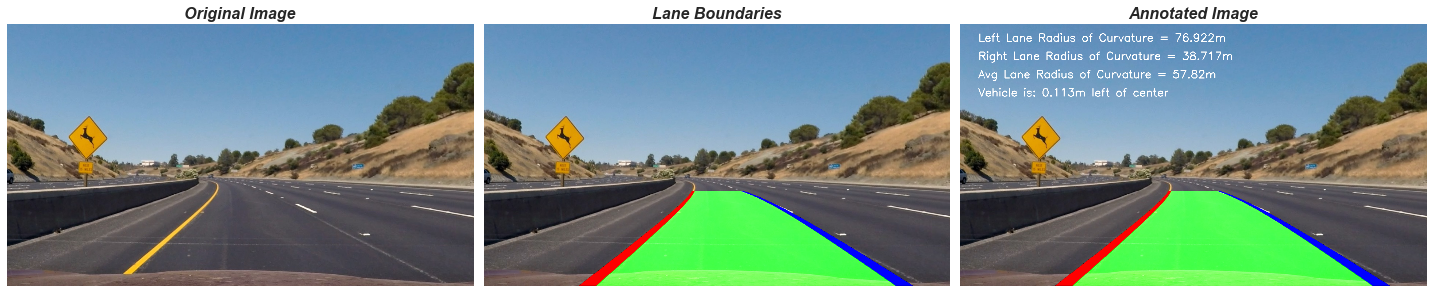

In [15]:
curvature = lf.LineCurvature(**params)
left_fitx, right_fitx = curvature.fit_lane_boundaries(window_centroids)
left_lane, right_lane, inner_lane = curvature.fit_lanes(left_fitx, right_fitx)
src,dst = pl.create_perspective_mappings(warped_img)
Minv = cv2.getPerspectiveTransform(dst.astype(np.float32), src.astype(np.float32))
img_lanes = curvature.view_lanes(undist_img, Minv, left_lane, right_lane, inner_lane)
img_annot = curvature.annotate_frame(img_lanes, window_centroids, left_fitx, right_fitx)
imgs = (undist_img, img_lanes, img_annot)
titles = ('Original Image', 'Lane Boundaries', 'Annotated Image')

fig, ax = plt.subplots(1,3, figsize=(20,6))
for axi, imgi, title in zip(ax, imgs, titles):
    axi.imshow(imgi)
    set_axi_opts(axi, **{'title': title, 'fontsize': 16})
plt.tight_layout()
fig.savefig('./output_images/pipeline_curvature_annotated.png', transparent=False, bbox_inches='tight')